# Tarea 2: Backpropagation, descenso de gradiente y entrenamiento <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: Gabriel Rojas C.
Fecha de entrega: 7 de octubre de 2021

Para la **corrección automática** hemos creado una funcionalidad nueva que les permite comprobar el tiempo que demora su solución. En colab estos tiempos pueden ser variables entre una ejecución y otra del mismo código. No se preocupen si les falla el test por `time` algunas veces. Pueden hacer `time=0` en la ultima linea de cada test para evitar estos errores. También hemos usado nombres para los tests. Estos pueden serles de ayuda para determinar qué partes de su implementación deben corregir ;-)


In [ ]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente:
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-_5x69xit/cc6204_0984eb44018b4ad5993d19528073a625
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-_5x69xit/cc6204_0984eb44018b4ad5993d19528073a625


In [ ]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

Connection stablished


# Parte 1: Preliminares: funciones de activación y función de error


## 1a) Derivando las funciones de activación

Escribe acá tus respuestas para las derivadas de cada función de activación.
<br>

\begin{equation}
\frac{\partial\ \text{relu}(x)}{\partial x} = \ldots \\
\end{equation}
<br>

\begin{eqnarray}
\frac{\partial\ \text{swish}(x, \ldots)}{\partial x} & = & \ldots \\
\frac{\partial\ \text{swish}(x, \ldots)}{\partial \ldots} & = & \ldots \\
\end{eqnarray}
<br>

\begin{eqnarray}
\frac{\partial\ \text{celu}(x, \ldots)}{\partial x} & = & \ldots \\
\frac{\partial\ \text{celu}(x, \ldots)}{\partial \ldots} & = & \ldots \\
\end{eqnarray}

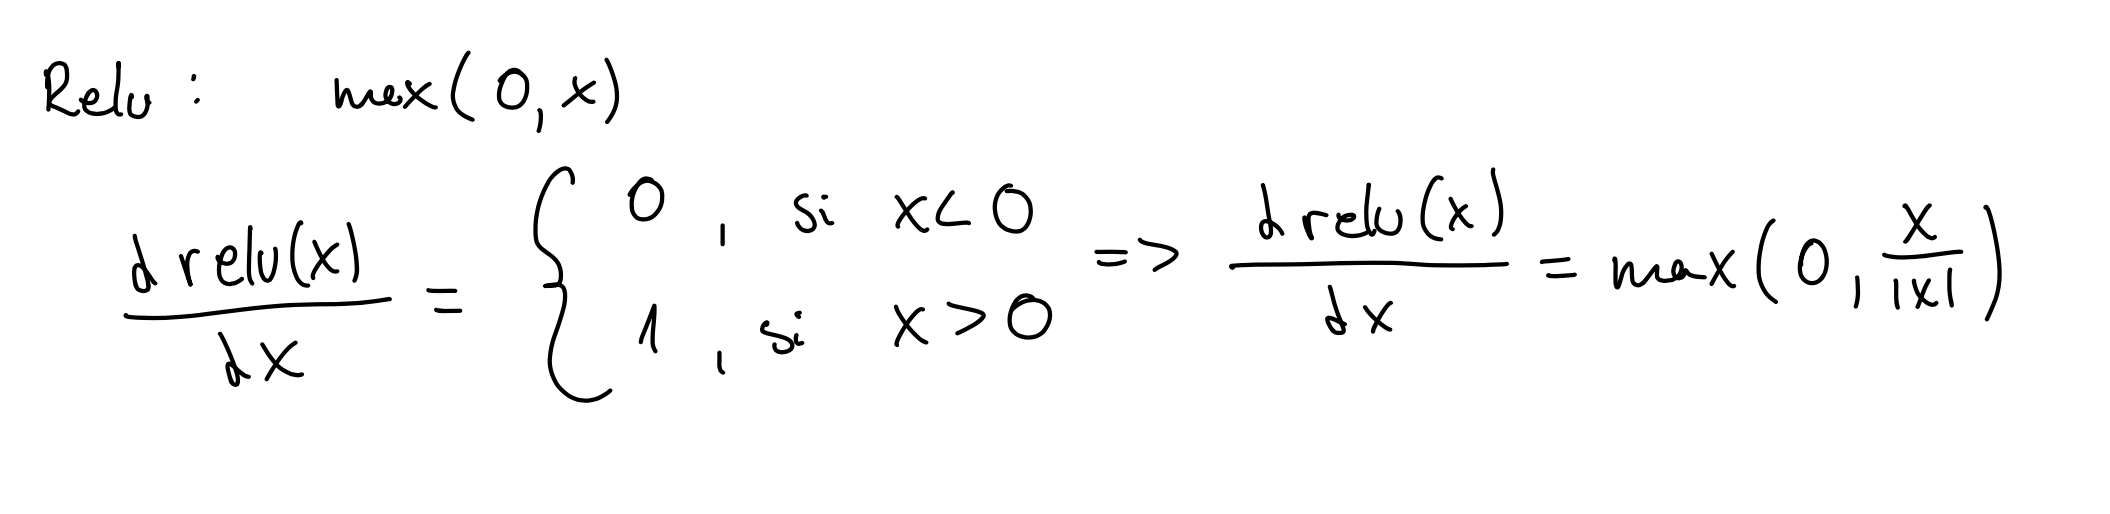
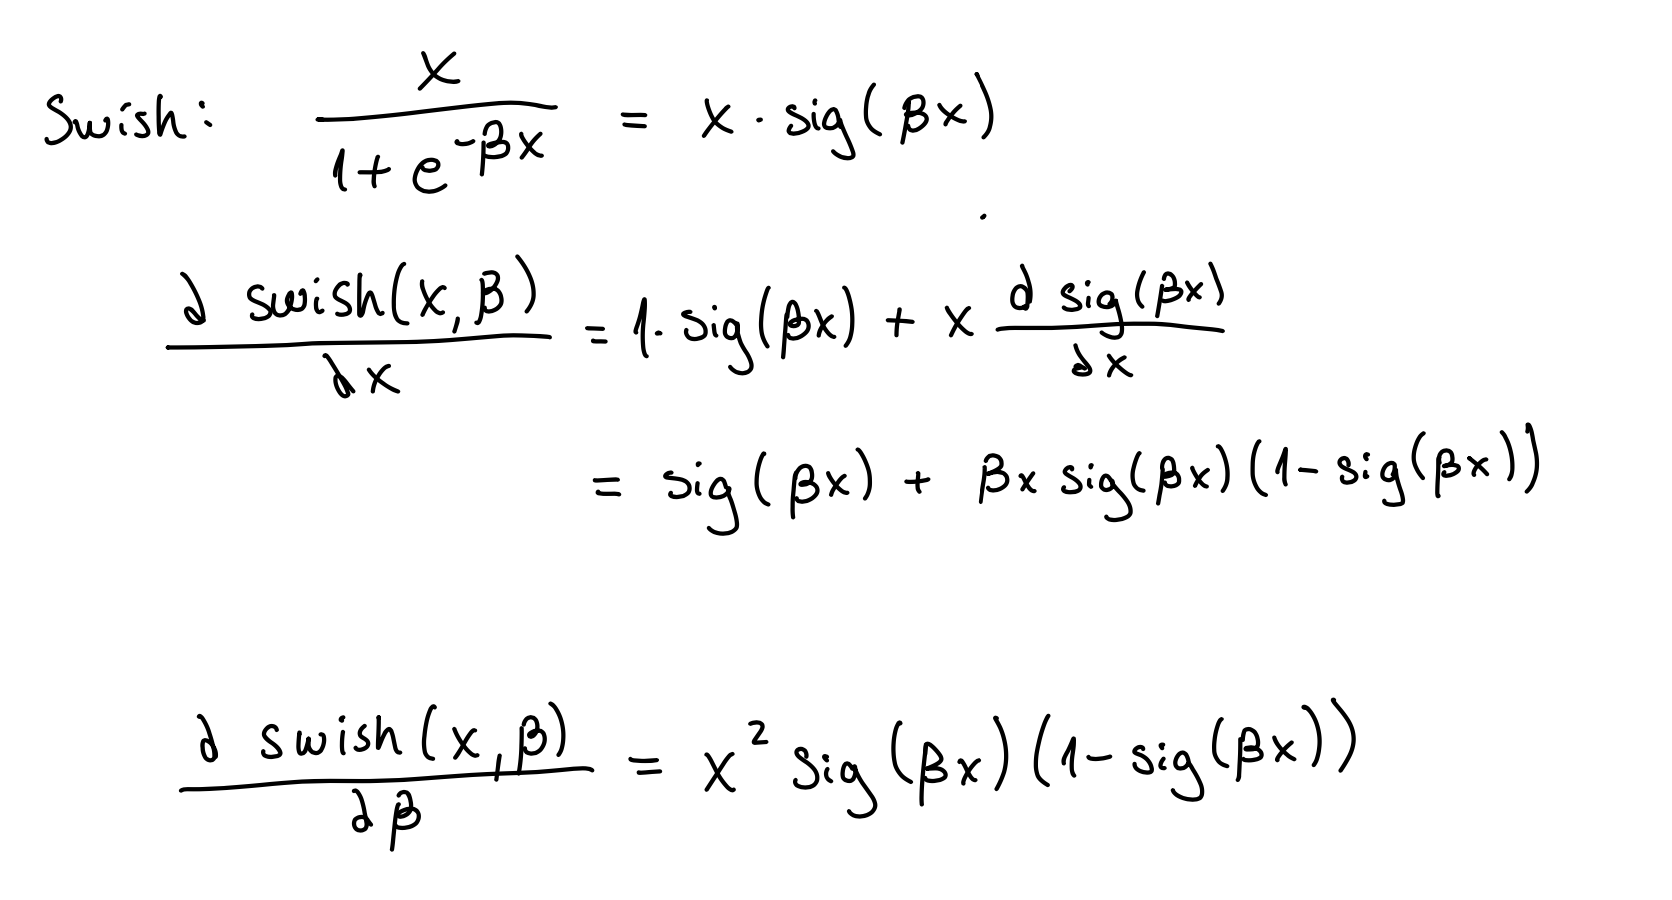
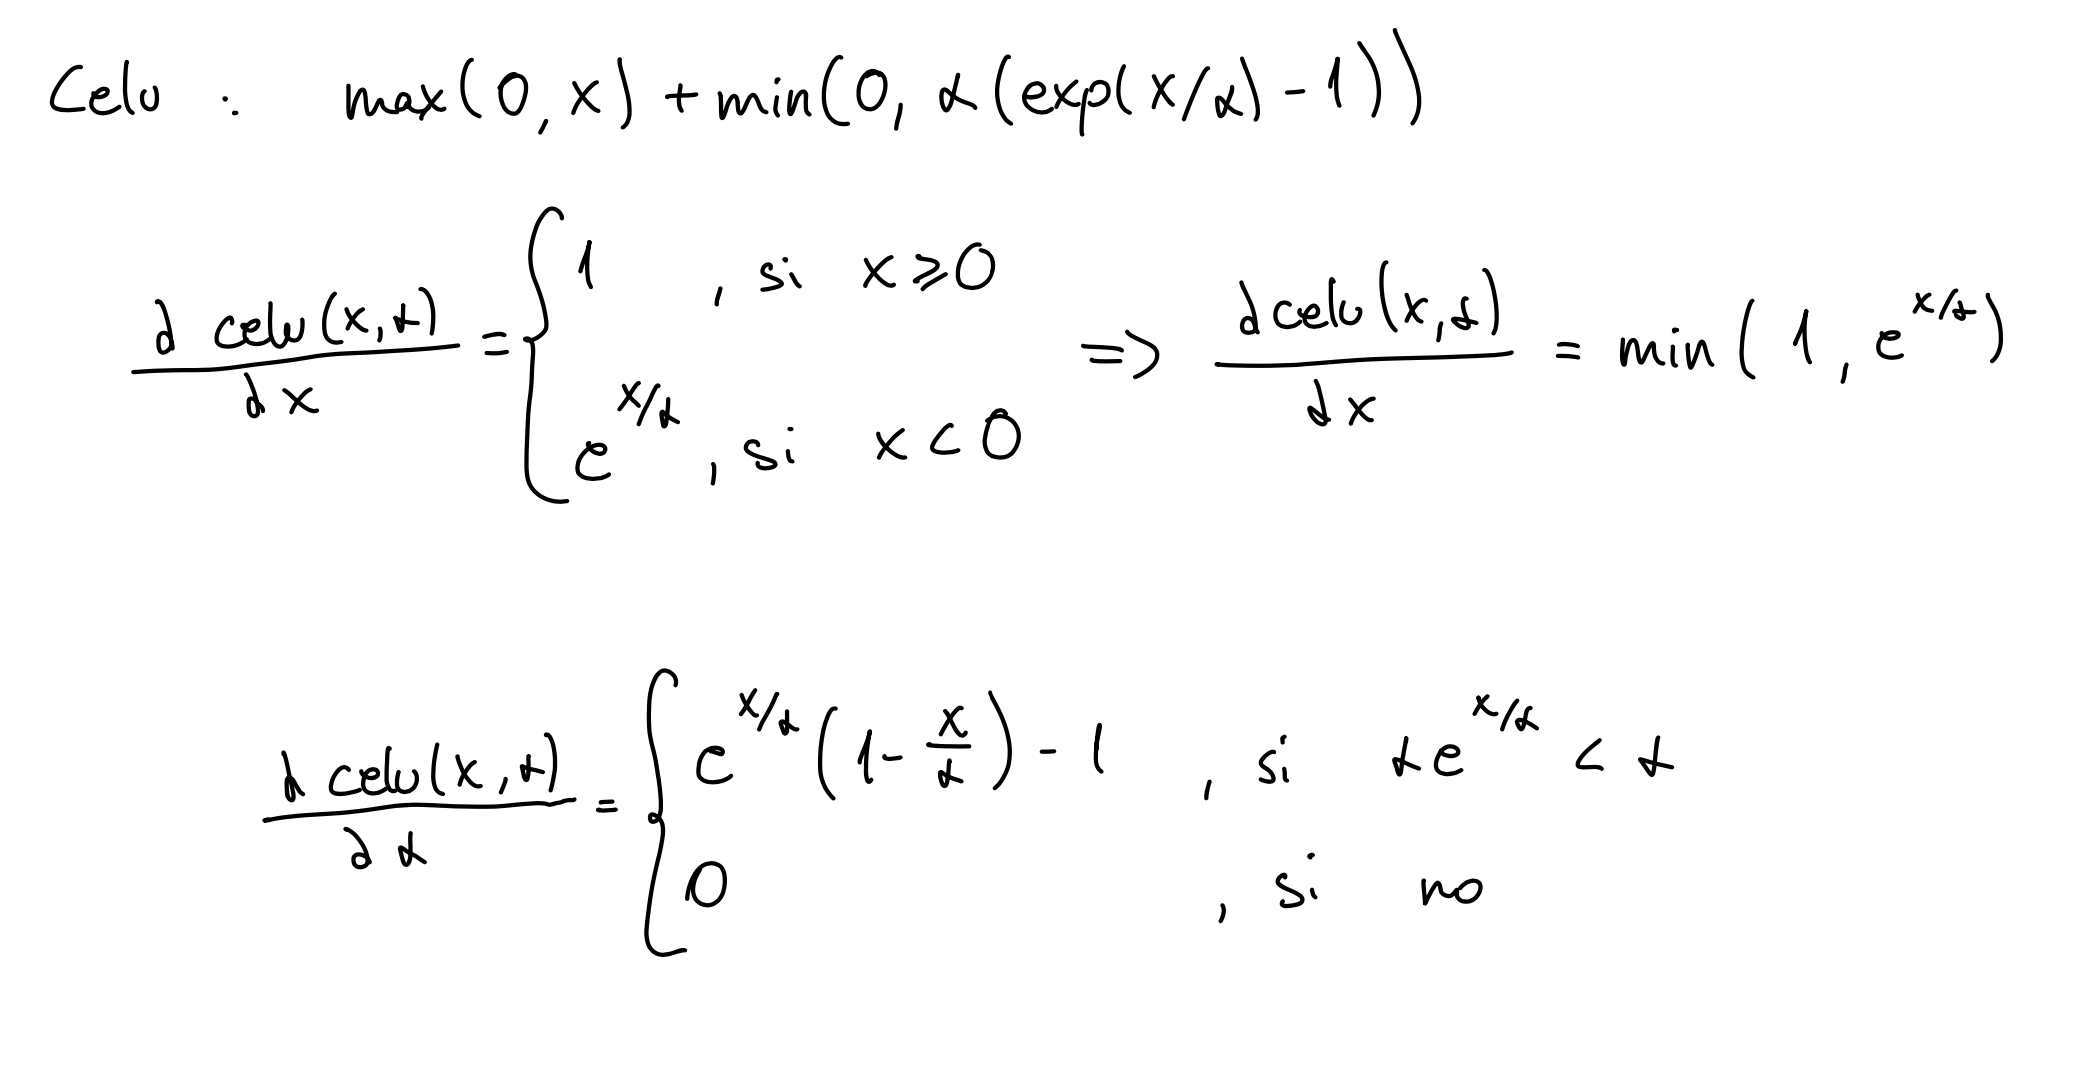

In [ ]:
# Más adelante en la tarea necesitaremos usar las funciones de activación 
# que implementaste en la Tarea 1 y sus derivadas.
# Acá implementa las derivadas de las funciones de activación

# Una forma de implementarlas (tal vez no la mejor) es reutilizando la misma función
class sig:
  def forward(T):
    return torch.reciprocal(1 + torch.exp(-1 * T))

  def backward(T):
    sig_T = sig.forward(T)
    return sig_T * (1 - sig_T)


class tanh:
  def forward(T):
    E = torch.exp(T)
    e = torch.exp(-1 * T)
    return (E - e) * torch.reciprocal(E + e)

  def backward(T):
    return torch.ones_like(T) - torch.square(tanh.forward(T))


class relu:
  def forward(T):
    return torch.max(T, torch.zeros_like(T))

  def backward(T):
    return torch.max(torch.zeros_like(T), torch.sign(T))


class swish:
  def forward(T, beta=1):
    return T * torch.reciprocal(1 + torch.exp(-beta * T) )

  def backward(T, beta=1):
    sig_bT = sig.forward(beta * T)
    return sig_bT + beta * T * sig_bT * (1 - sig_bT)


class celu:
  def forward(T, alpha=1):
    if alpha == 0:
      raise ValueError("alpha cannot be 0")
    zeros = torch.zeros_like(T)
    return torch.max(zeros, T) + torch.min(zeros, alpha * (T / alpha).expm1())

  def backward(T, alpha=1):
    return torch.min(torch.zeros_like(T), torch.exp(T / alpha))


def softmax(T, dim=1, estable=True):
  if estable:
    T = T - torch.max(T,dim,keepdim=True)[dim-1]
  exp = torch.exp(T)
  tot = torch.sum(exp, dim, keepdim = True)
  return exp/tot


## 1b) Entropía Cruzada

In [ ]:
# Tu código acá
def CELoss(Q, P, estable=True, epsilon=1e-8):
  # Q y P: representan distribuciones de probabilidad discreta  
  #        (mediante matrices con las mismas dimensiones)
  #        estable y epsilon: nos permiten lograr estabilidad numérica cuando 
  #        intentamos computar el logaritmo de valores muy pequeños.
  #        epsilon limitará el valor mínimo del valor original cuando estable=True
  if estable:
    min_val = torch.log(torch.tensor(epsilon))
    log_Q = torch.max(min_val, torch.log(Q))
    return torch.sum(-torch.sum(P * log_Q, dim=-1)) / Q.size(0)
  else:
    log_Q = torch.log(Q)
    return torch.sum(-torch.sum(P * log_Q, dim=-1)) / Q.size(0)

In [ ]:
# Tests del API del curso
for test in ['small', 'estable', 'eps', 'no-estable']:
  # Obtengamos dos distribuciones de probabilidad y los parametros estable y epsilon
  Q, P, estable, eps = corrector.get_test_data(homework=2, question="1b", test=test, token=token)
  # Corramos tu implementacion de CELoss para ver como se comporta
  s = timer()
  result = CELoss(Q=torch.Tensor(Q), P=torch.Tensor(P), estable=estable, epsilon=eps)
  t = timer() - s

  # Veamos si todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.submit(homework=2, question="1b", test=test, token=token, answer=result, time=0)

Correct Test!
Correct Test!
Correct Test!
Correct Test!


## 1c) Opcional: Entropía Cruzada Categórica

In [ ]:
# No es necesario que entregues código en esta parte.
# Pero si quieres, igual hay espacio ;-)

# Parte 2: Más derivadas y back propagation

## 2a) Derivando la última capa

Escribe tu cálculo acá.
<br>

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}} =
\end{equation}
<br>
(No es necesario que repitas el código que era solo de ayuda para chequear las dimensiones.)

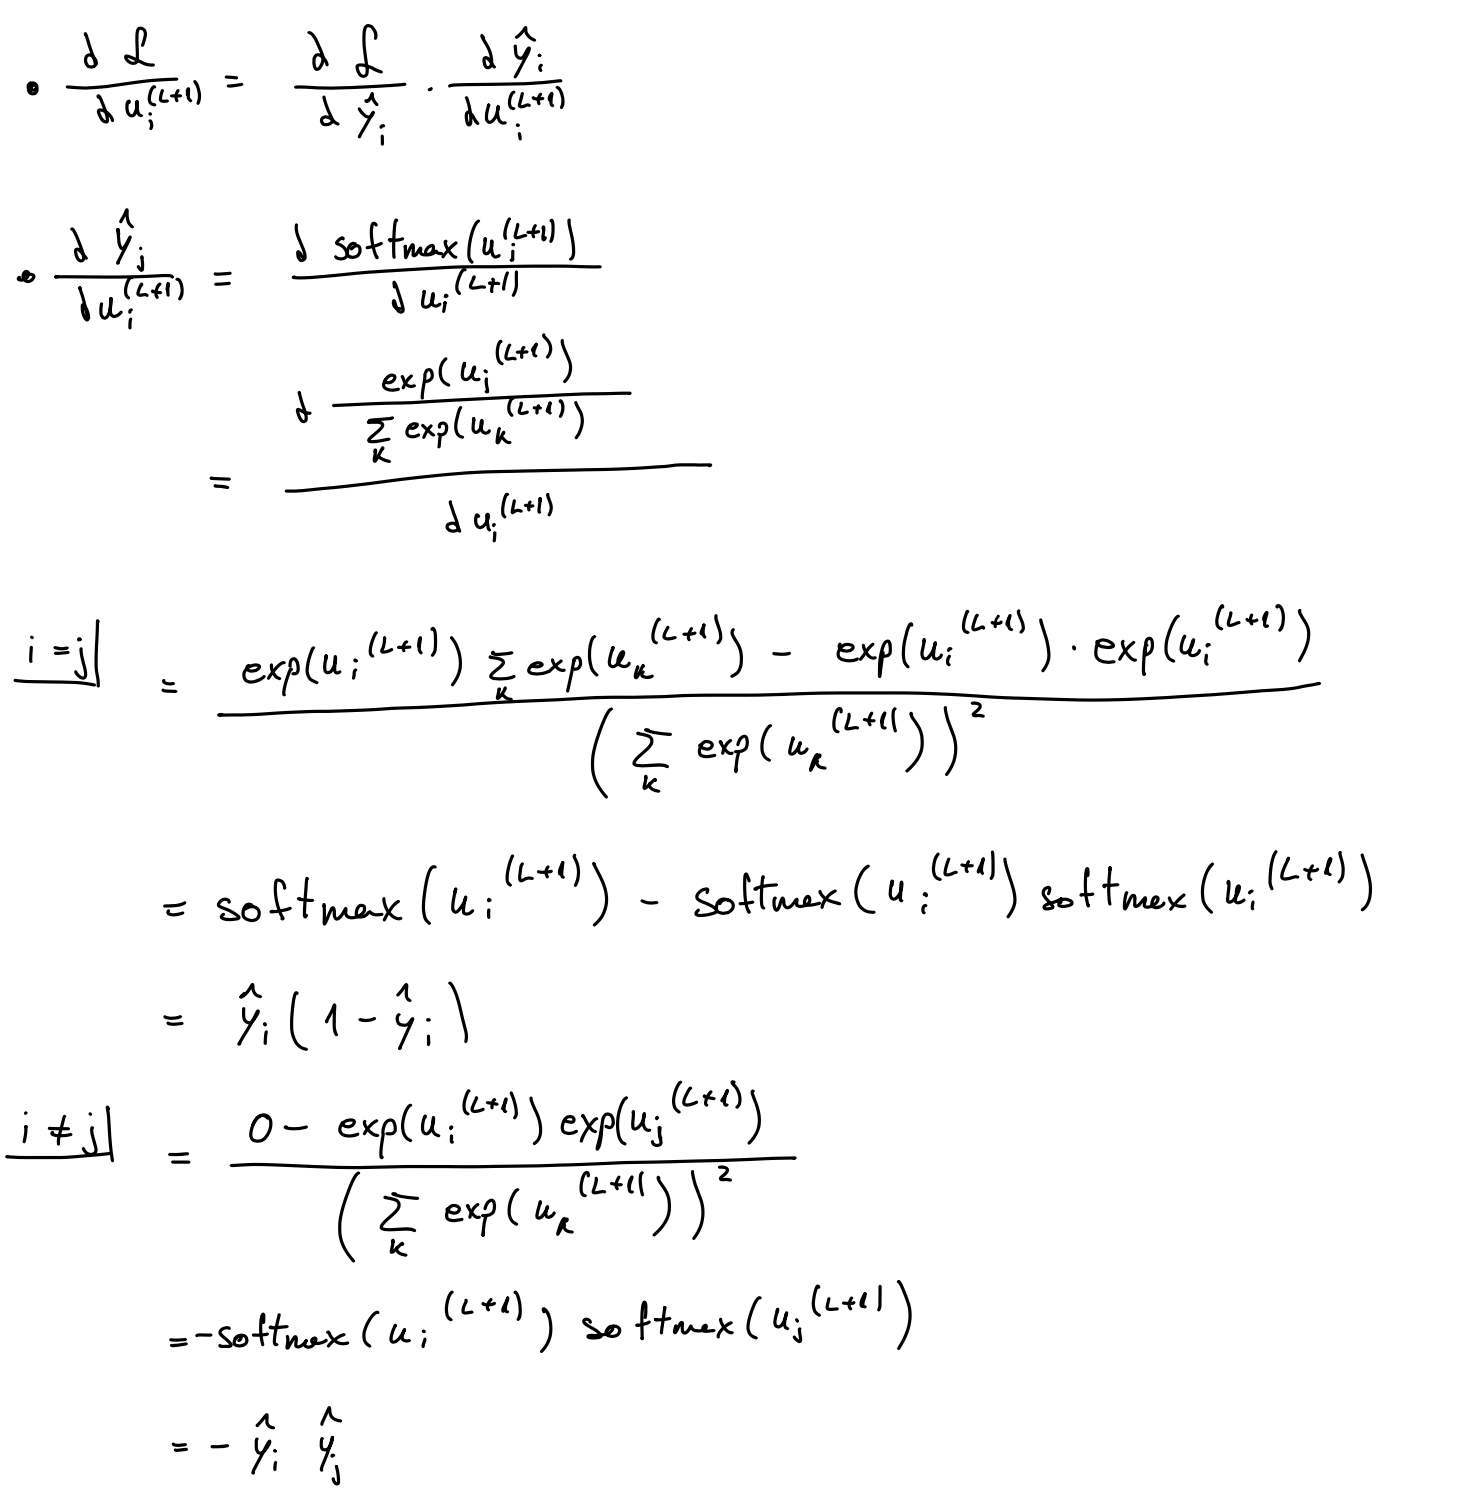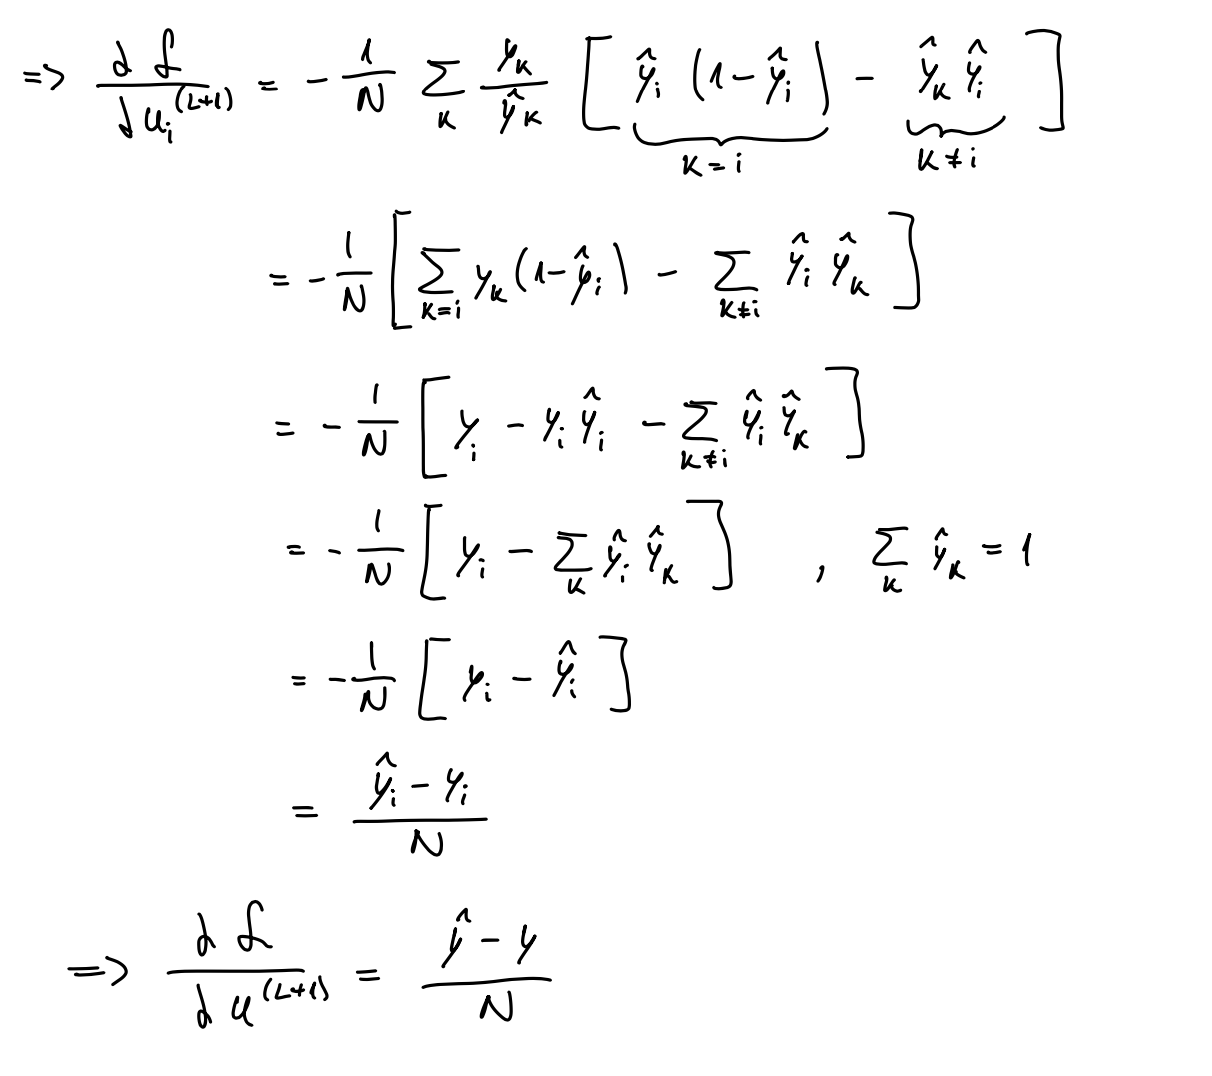

## 2b) Derivando la última capa (continuación)

Escribe tus respuestas acá.
<br>

\begin{equation}
\frac{\partial\cal L}{\partial U} = \ldots \\
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial c} = \ldots \\
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(L)}} = \ldots \\
\end{equation}
<br>
(No es necesario que repitas el código que era solo de ayuda para chequear las dimensiones.)

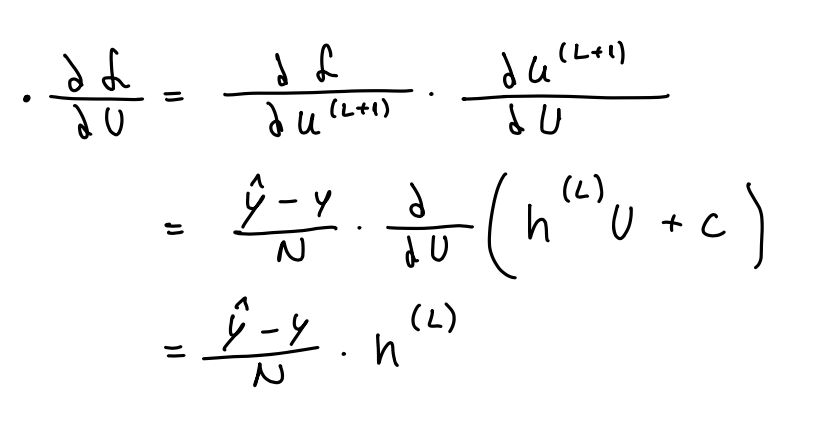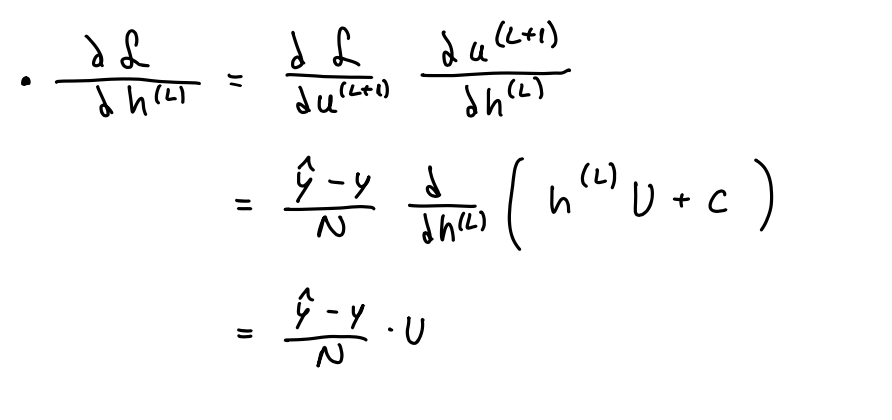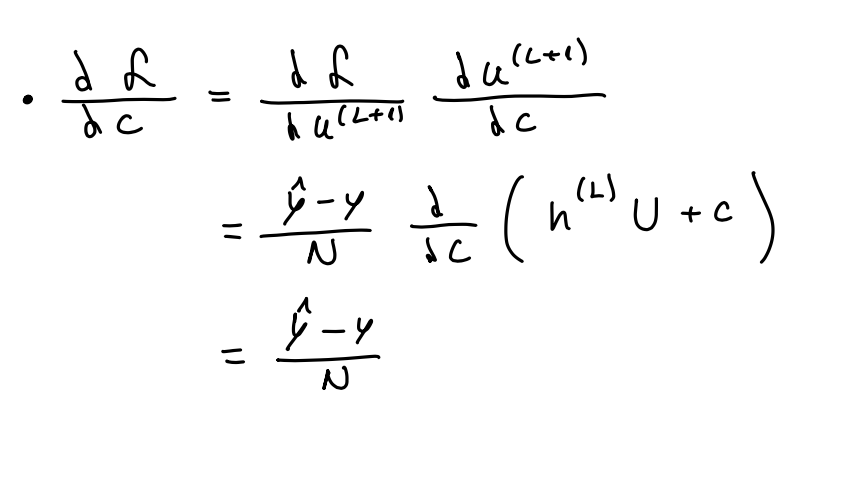

## 2c) Derivando desde las capas escondidas

Escribe tus respuestas acá. Repite los siguientes cálculos para $\text{relu}, \text{celu}, \text{swish}$
<br>

\begin{equation}
\frac{\partial\cal L}{\partial u^{(k)}} = \ldots \\
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial W^{(k)}} = \ldots \\
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial b^{(k)}} = \ldots \\
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(k-1)}} = \ldots \\
\end{equation}
<br>
(No es necesario que repitas el código que era solo de ayuda para chequear las dimensiones.)

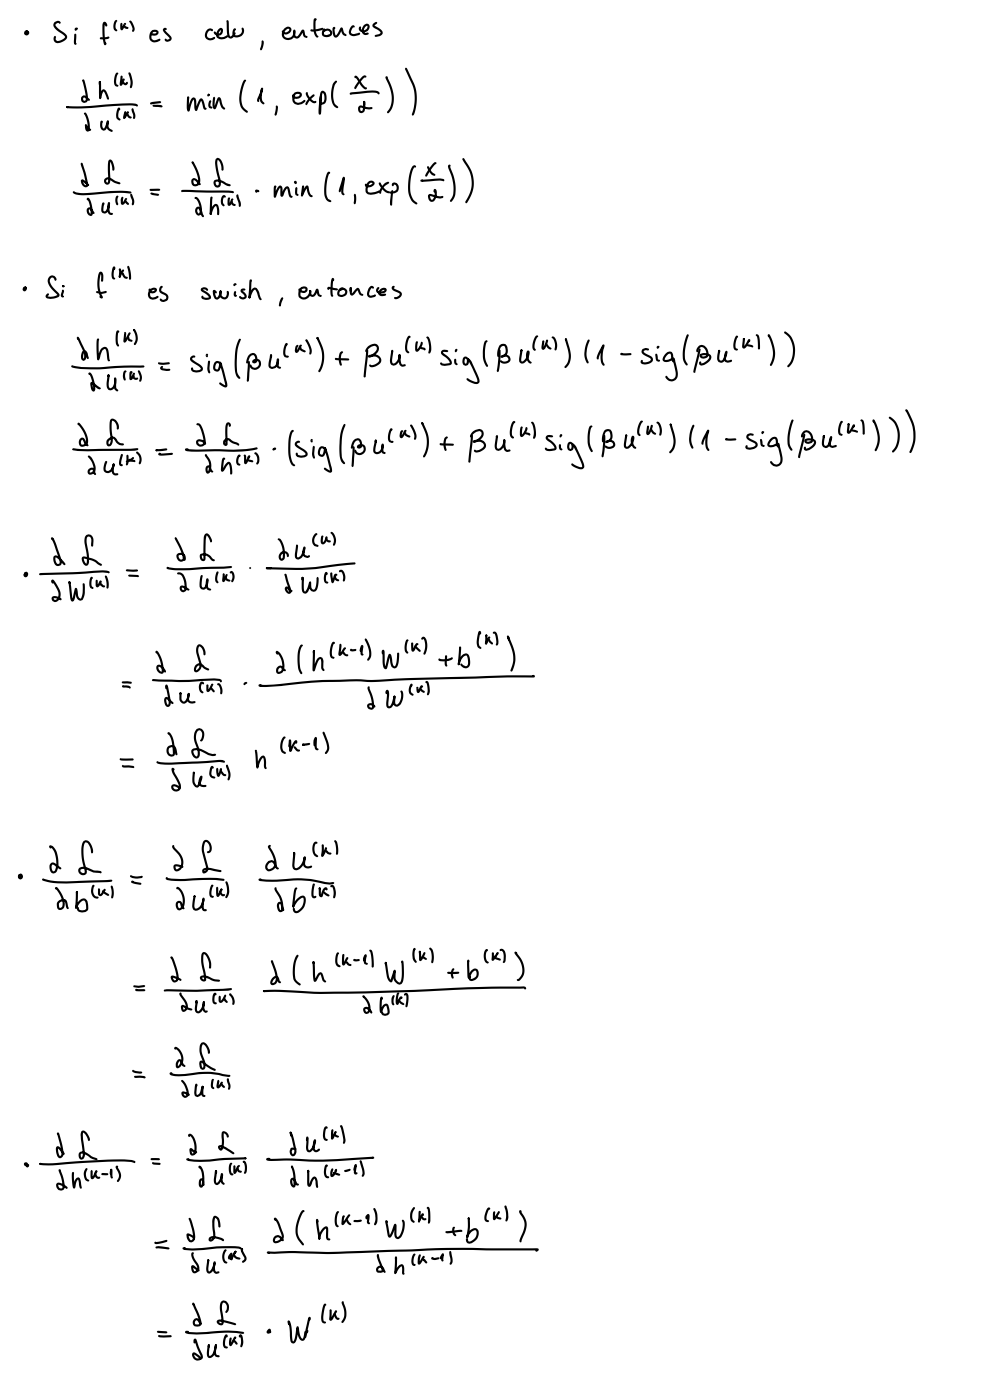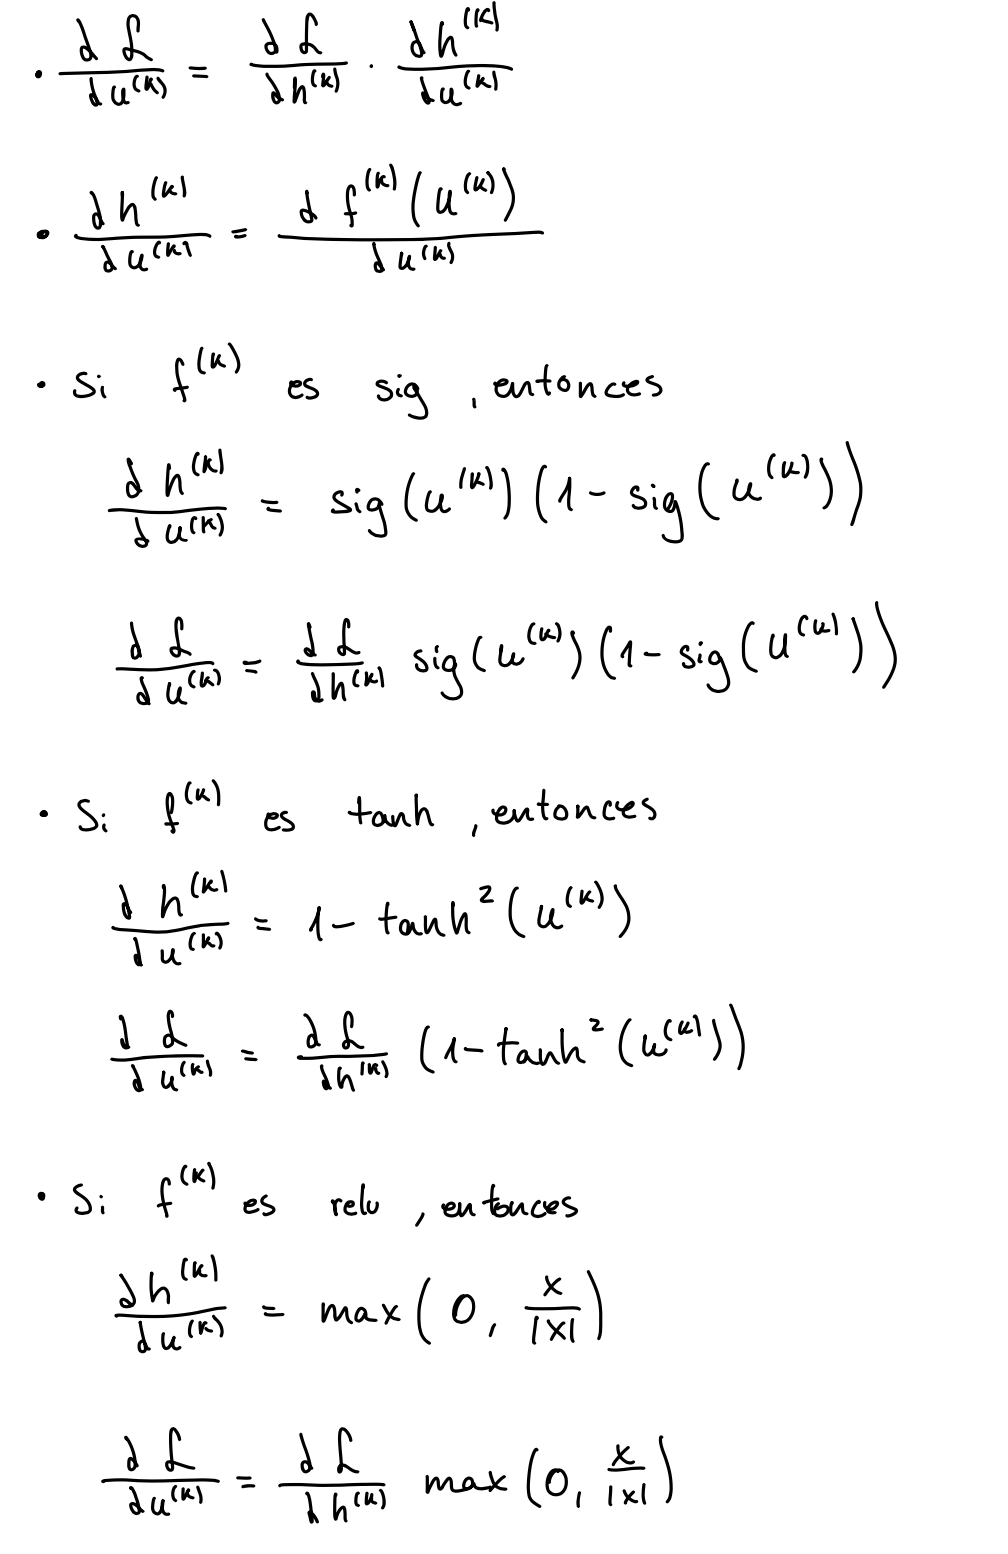

# Parte 3: Backpropagation en nuestra red

## 3a) Método `backward` + parte 3b) Opcional

In [ ]:
# Acá solo deberías programar la función backward.
# El resto del código viene de la Tarea 1 (a menos que hayas programado
# la parte opcional en cuyo caso también deberías cambiar el inicializador).
# Puedes incluir todo el código de la Tarea 1 que quieras.
# Tu código debiera continuar aquí 

class FFNN(torch.nn.Module):
  # código desde la Tarea 1
  def __init__(self, F, l_h, l_a, l_a_params, C):
    super(FFNN, self).__init__()
    sizes = [F] + l_h + [C]
    self.num_features = F
    k = torch.sqrt(torch.reciprocal(torch.tensor(F)))
    self.Ws = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(sizes[i], sizes[i+1]) * k) for i in range(len(sizes)-1)])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(h) * k) for h in sizes[1:]])
    self.fs = l_a
    self.fs_ps = l_a_params
    self.us = []
    self.hs = []

  # código desde la Tarea 1
  def load_weights(self, Ws, U, bs, c):
    self.Ws = torch.nn.ParameterList([torch.nn.Parameter(W) for W in Ws + [U]])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(b) for b in bs + [c]])

  # código desde la Tarea 1
  def resumen(self):
    for name, p in self.named_parameters():
      print('{}:\t{}'.format(name, p.size()))
  
  # código desde la Tarea 1
  def forward(self, x):
    for W, b, f, p in zip(self.Ws[:-1], self.bs[:-1], self.fs, self.fs_ps):
      u = torch.mm(x, W) + b
      self.us.append(u)
      x = f.forward(u) if p is None else f.forward(u, p)
      self.hs.append(x)
    return softmax(torch.mm(x, self.Ws[-1]) + self.bs[-1], dim=1)

  # nuevo código Tarea 2
  def backward(self, x, y, y_pred):
    # Computar acá todos los gradientes con respecto a L
    # Hint: Los gradientes deben quedar almacenados en 
    #       el atributo `grad` para cada parámetro.
    #       Más info sobre este atributo en
    #       https://pytorch.org/docs/stable/autograd.html#torch.Tensor.grad
    N = x.size()[0]
    dL_du = 1 / N * (y_pred - y)

    for W, b, f, p, u, h in zip(self.Ws[1:][::-1], self.bs[1:][::-1], self.fs[::-1], self.fs_ps[::-1], self.us[::-1], self.hs[::-1]):
      dL_dW = torch.mm(h.t(), dL_du)
      dL_db = torch.sum(dL_du, 0)
      dL_dh = torch.mm(dL_du, W.t())
      f_backward = f.backward(u) if p is None else f.backward(u, p)
      dL_du = dL_dh * f_backward
      W.grad = dL_dW
      b.grad = dL_db

    dL_dW = x.t() @ dL_du
    dL_db = torch.sum(dL_du, 0)
    self.Ws[0].grad = dL_dW
    self.bs[0].grad = dL_db


In [ ]:
# Tests del API del curso
# (estos Tests NO sustituyen al anterior en la verificación de los gradientes)
for test in ['mnist-model']:
  # Obtenemos los parámetos de la red desde el API
  F, l_h, l_a, C, Ws, U, bs, c, X, y = corrector.get_test_data(homework=2, question="3a", test=test, token=token)
  l_a = [f for s in l_a for f in [sig, tanh, relu, celu] if f.__name__ == s]

  # Inicializamos modelo con parámetros del API
  params = [None]*len(l_a)
  your_model = FFNN(F=F, l_h=l_h, l_a=l_a, l_a_params=params, C=C)
  your_model.load_weights([torch.Tensor(l) for l in Ws], torch.Tensor(U), [torch.Tensor(l) for l in bs], torch.Tensor(c))
  
  # Obtenemos el índice del parámetro Ws[1] en la lista de parámetros de tu modelo
  idx = next(i for i, p in enumerate(your_model.parameters()) if p.size() == torch.Tensor(Ws[1]).size() and torch.all(torch.Tensor(Ws[1])==p))

  # Ejecutemos el forward de para input del API
  y_pred = your_model(torch.Tensor(X))
  
  # Ejecutemos el backward de tu modelo para ver como se comporta
  s = timer()
  your_model.backward(torch.Tensor(X), torch.Tensor(y), y_pred)
  t = timer() - s
  
  # Veamos todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.submit(homework=2, question="3a", test=test, token=token, 
                   answer=list(your_model.parameters())[idx].grad.mean(), time=0)

Correct Test!


## 3c) Opcional: Chequeo de gradiente

In [ ]:
# No es necesario que entregues código en esta parte dado 
# que solo es necesario para debuggear que tu implementación está correcta.
# Pero si quieres, igual hay espacio ;-)

# Parte 4: Descenso de gradiente y optimización

## 4a) Descenso de gradiente (estocástico)

In [ ]:
# Tu código debiera comenzar así

class SGD():
  def __init__(self, parameters, lr):
    # lo que sea necesario inicializar
    if lr<0:
      raise Exception("lr must be greater than 0")
    self.parameters = list(parameters)
    self.lr = lr
  
  def step(self):
    # actualiza acá los parámetros a partir del gradiente de cada uno
    for p in self.parameters:
      p.data -= self.lr * p.grad


In [ ]:
# Tests del API del curso
from torch.nn import Parameter
for test in ['small-step', 'big-step', 'random']:
  # Obtengamos una lista de parámetros (con gradientes en .grad) y un valor lr
  ds, gs, lr, idx = corrector.get_test_data(homework=2, question="4a", test=test, token=token)
  parameters = [Parameter(torch.Tensor(d)) for d in ds]
  for p, g in zip(parameters, gs):
    p.grad = torch.Tensor(g)

  # Inicialicemos tu SGD
  optimizer = SGD(parameters, lr)

  # Ejecutemos un paso de tu SGD para ver como se comporta
  s = timer()
  optimizer.step()
  t = timer() - s

  # Veamos si todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.submit(homework=2, question="4a", test=test, token=token, 
                   answer=parameters[idx].data, time=0)

Correct Test!
Correct Test!
Correct Test!


## 4b) Datos para carga

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Aquí tu código.
# Tu clase debiera verse así
class RandomDataset(Dataset):
  def __init__(self, N, F, C):
    self.X = torch.rand(N, F)
    self.Y = torch.rand(N, C)
    self.num_features = F
  
  def __len__(self):
    return self.X.size()[0]
  
  def __getitem__(self, i):
    return self.X[i], self.Y[i]

In [ ]:
# Inicialicemos un RandomDataset de prueba
N,F,C=100,300,10
your_dataset = RandomDataset(N, F, C)

# Veamos como se comportan __len__ y __getitem__
print("Correct Test!" if len(your_dataset) == N else "Failed Test [len]") 
print("Correct Test!" if type(your_dataset[N//2]) == tuple and len(your_dataset[N//3]) == 2 else "Failed Test [getitem]")

Correct Test!
Correct Test!


## 4c) Optimizando los parámetros de la red para datos al azar

In [ ]:
# Tu código acá
import sys
import time
def entrenar_FFNN(red, dataset, optimizador, epochs=1, batch_size=1, device='cuda', verbose=False):
  red.to(device)
  
  # Inicialicemos un DataLoader para los ejemplos de dataset
  data = DataLoader(dataset, batch_size, shuffle=True)

  # Comienza el entrenamiento
  loss, acc = [], []
  tiempo_epochs = 0
  for e in range(1,epochs+1):
    running_loss = 0
    correct = 0
    total = 0
    inicio_epoch = time.time()
    for x, y in data:
      x, y = x.to(device), y.to(device)

      y_pred = red.forward(x)
      l = CELoss(y_pred, y)
      red.backward(x, y, y_pred)
      optimizador.step()

      running_loss += l
      y_pred = y_pred.max(1)[1]
      total += y.size(0)
      correct += y_pred.eq(y.max(1)[1]).sum().item()

    tot_loss = running_loss / len(dataset)
    accu = correct / total * 100.0
    loss.append(tot_loss)
    acc.append(accu)

    tiempo_epochs += time.time() - inicio_epoch

    if verbose:
      sys.stdout.write('\rEpoch:{0:03d}'.format(e) + ' Acc:{0:.2f}%'.format(accu)
            + ' Loss:{0:.4f}'.format(tot_loss)
            + ' Tiempo/epoch:{0:.3f}s'.format(tiempo_epochs/e))

  return loss, acc


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
F, C = 300, 10

N = 1000
dataset = RandomDataset(N, F, C)


In [ ]:
# model 1 training
model1 = FFNN(F, [50, 30], [relu, sig], [None, None], C)
optimizer1 = SGD(model1.parameters(), 0.001)

with torch.no_grad():
  loss1, acc1 = entrenar_FFNN(model1, dataset, optimizer1, epochs=20, batch_size=8, device=device, verbose=True)


Epoch:020 Acc:12.30% Loss:1.4453 Tiempo/epoch:0.174s

In [ ]:
# model 2 training
model2 = FFNN(F, [150, 75], [relu, sig], [None, None], C)
optimizer2 = SGD(model2.parameters(), 0.05)

with torch.no_grad():
  loss2, acc2 = entrenar_FFNN(model2, dataset, optimizer2, epochs=20, batch_size=8, device=device, verbose=True)


Epoch:020 Acc:8.40% Loss:1.5134 Tiempo/epoch:0.196s

In [ ]:
# model 3 training
model3 = FFNN(F, [50 , 30], [tanh, sig], [None, None], C)
optimizer3 = SGD(model3.parameters(), 0.001)

with torch.no_grad():
  loss3, acc3 = entrenar_FFNN(model3, dataset, optimizer3, epochs=20, batch_size=8, device=device, verbose=True)


Epoch:020 Acc:12.30% Loss:1.4452 Tiempo/epoch:0.181s

## 4d) Graficando la pérdida/error en el tiempo

In [ ]:
import matplotlib.pyplot as plt

def plot_results(loss, acc):
  # Muestra dos figuras: 
  #  (1) gráfico para la lista `loss` (Loss) y 
  #  (2) gráfico para la lista `acc` (Accuracy)

  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title("Accuracy")    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('acc')
  ax2.plot(acc, c='b')
  f2.show()

Model 1


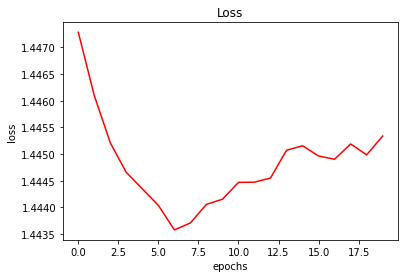

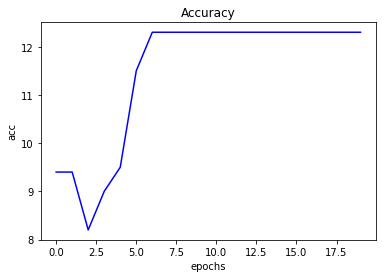

In [ ]:
print("Model 1")
plot_results(loss1, acc1)

Model 2


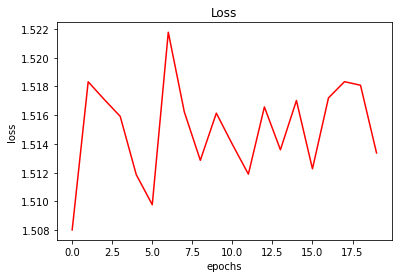

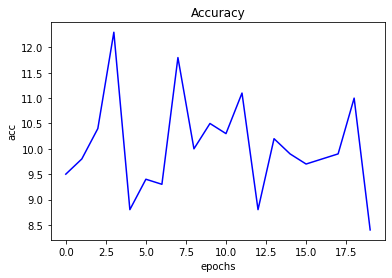

In [ ]:
print("Model 2")
plot_results(loss2, acc2)

Model 3


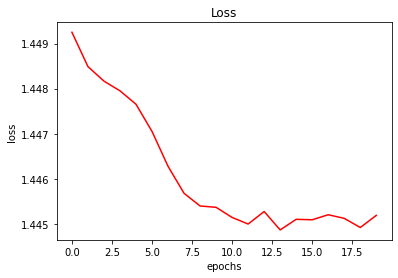

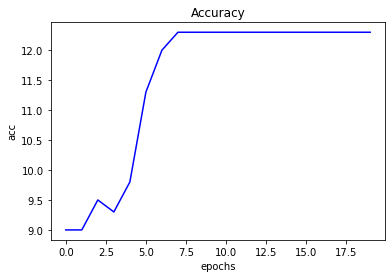

In [ ]:
print("Model 3")
plot_results(loss3, acc3)

## 4e) Opcional: Optimizando tu red para MNIST

In [ ]:
# Tu código de carga de datos, creación de la red, 
# entrenamiento/optimización y reportes acá
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Importamos funcionalidades útiles para mirar los datos.
from matplotlib.pyplot import subplots
from random import randint

# Descarga y almacena el conjunto de prueba de MNIST.
train_dataset = MNIST('mnist', train=True, transform=ToTensor(), download=True)
test_dataset = MNIST('mnist', train=False, transform=ToTensor(), download=True)
print('Cantidad total de datos de entrenamiento:',len(train_dataset))
print('Cantidad total de datos de testeo:',len(test_dataset))

Cantidad total de datos de entrenamiento: 60000
Cantidad total de datos de testeo: 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def train_mnist_FFNN(red, dataset, optimizador, epochs=1, batch_size=1, device='cuda', verbose=False):
  red.to(device)
  
  # Inicialicemos un DataLoader para los ejemplos de dataset
  data = DataLoader(dataset, batch_size, shuffle=True)

  # Comienza el entrenamiento
  loss, acc = [], []
  tiempo_epochs = 0
  for e in range(1,epochs+1):
    running_loss = 0
    correct = 0
    total = 0
    inicio_epoch = time.time()
    for x, y in data:
      x, y = x.to(device), y.to(device)
      x = x.view(-1,784)
      y = torch.nn.functional.one_hot(y, num_classes=C).to(device)

      y_pred = red.forward(x)
      l = CELoss(y_pred, y)
      red.backward(x, y, y_pred)
      optimizador.step()

      running_loss += l
      y_pred = y_pred.max(1)[1]
      total += y.size(0)
      correct += y_pred.eq(y.max(1)[1]).sum().item()

    tot_loss = running_loss / len(dataset)
    accu = correct / total * 100.0
    loss.append(tot_loss)
    acc.append(accu)

    tiempo_epochs += time.time() - inicio_epoch

    if verbose:
      sys.stdout.write('\rEpoch:{0:03d}'.format(e) + ' Acc:{0:.2f}%'.format(accu)
            + ' Loss:{0:.4f}'.format(tot_loss)
            + ' Tiempo/epoch:{0:.3f}s'.format(tiempo_epochs/e))

  return loss, acc


In [ ]:
N, F, C = len(train_dataset), 28*28, 10
red_mnist = FFNN(F, [500], [relu], [None], C)
optimizer_mnist = SGD(red_mnist.parameters(), 0.001)
total_loss_mnist = []
total_acc_mnist = []

In [ ]:
epochs = 20
with torch.no_grad():
  loss_mnist, acc_mnist = train_mnist_FFNN(red_mnist, train_dataset, optimizer_mnist,
                                          epochs=epochs, batch_size=100, device=device,
                                          verbose=True)
  total_loss_mnist += loss_mnist
  total_acc_mnist += acc_mnist


Epoch:020 Acc:88.11% Loss:0.0047 Tiempo/epoch:8.893s

In [ ]:
def calcula_acierto(red, dataset, batch_size=100, device='cuda'):
  red.to(device)
  data_loader = DataLoader(dataset, batch_size=batch_size)
  corrects_total = 0
  for i, (x, y) in enumerate(data_loader):
      x = x.view(-1, red.num_features).to(device)
      
      predictions = torch.max(red(x), dim=1)[1]
      corrects = int((predictions == y.to(device)).sum())
      corrects_total += corrects
      
      if i % 10 == 0:
        print('iter {} of {}'.format(i, len(data_loader)))

  print('Acc: {}%'.format(100*corrects_total/len(dataset)))

In [ ]:
calcula_acierto(red_mnist, test_dataset, device=device)

iter 0 of 100
iter 10 of 100
iter 20 of 100
iter 30 of 100
iter 40 of 100
iter 50 of 100
iter 60 of 100
iter 70 of 100
iter 80 of 100
iter 90 of 100
Acc: 88.88%


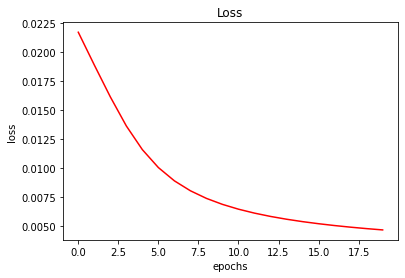

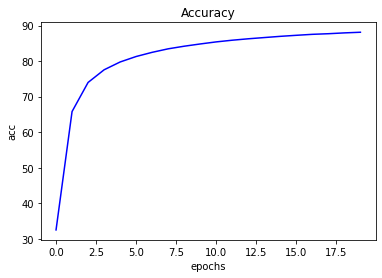

In [ ]:
plot_results(loss_mnist, acc_mnist)